# Delay discounting task using ADOpy

## Load packages

In [1]:
# Install packages
!pip install numpy scipy pandas matplotlib adopy

In [2]:
import numpy as np
import pandas as pd

# Set print-related options for NumPy and Pandas
np.set_printoptions(precision=4, threshold=10)
pd.set_option("display.max_rows", 7)

## Task & Model Descriptions

### Delay discounting task (e.g., Green & Myerson, 2004)

<img width="500px" src="https://github.com/adopy/adopy/raw/master/examples/dd/thumbnail.png">
  
  - **4 design variables**
    - **`t_ss` ($t_{SS}$)**: Delay for the SS (smaller, sooner) option
    - **`t_ll` ($t_{LL}$)**: Delay for the LL (larger, later) option
        - The delay on SS option should be sooner than that of LL option ($t_{SS} < t_{LL}$).
    - **`r_ss` ($R_{SS}$)**: Reward value for the SS (smaller, sooner) option
    - **`r_ll` ($R_{LL}$)**: Reward value for the LL (larger, later) option
        - The reward on SS option should be smaller than that of LL option ($R_{SS} < R_{LL}$).
- **Possible responses**: `0` (SS option), `1` (LL option)

### Model: Hyperbolic model (Mazur, 1987)

$$
\begin{aligned}
    \text{discounting factor} \; D(t) &= \frac{1}{1 + kt} \\
    V_{SS} &= R_{SS} \cdot D(t_{SS}) \\
    V_{LL} &= R_{LL} \cdot D(t_{LL}) \\
    P(LL \, over \, SS) &= \frac{1}{1 + \exp [- \tau \cdot \gamma (V_{LL} - V_{SS})]}
\end{aligned}
$$

- **Model parameters**
    - **`k` ($k$)**: discounting rate parameter
    - **`tau` ($\tau$)**: inverse temperature

## Implementation using ADOpy

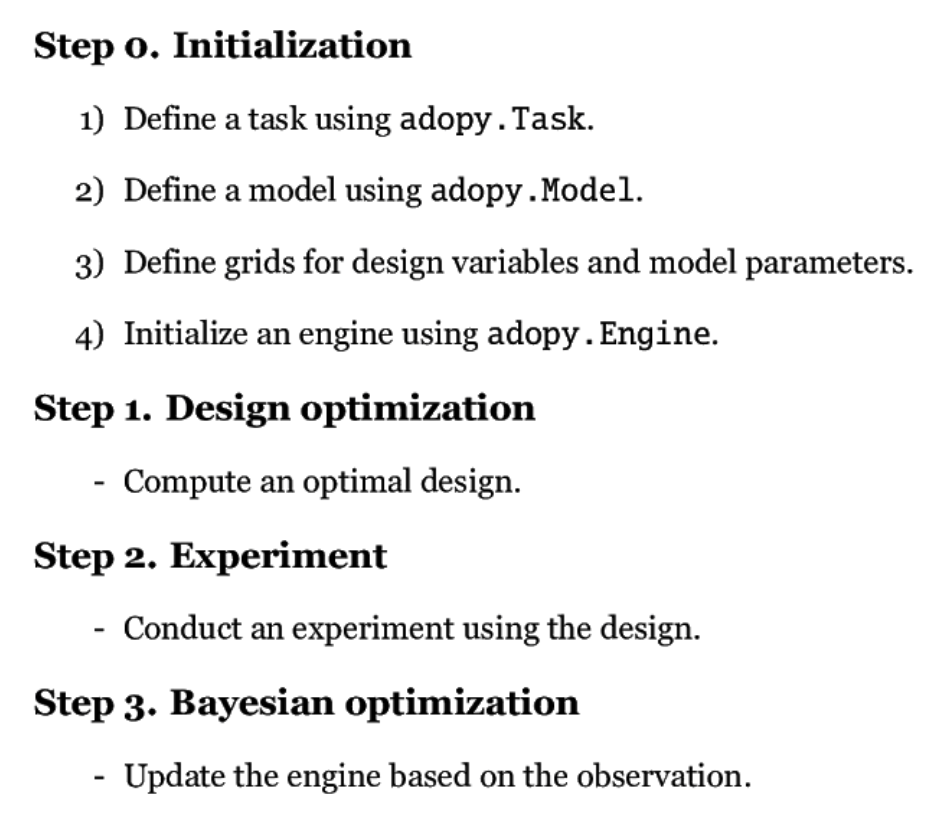

### Step 0. Initialization

#### 1) Define a task using `adopy.Task`

In [3]:
# Load a Task class from adopy
from adopy import Task

# Define a task using the Task class
task = Task(name='Delay discounting task',
            designs=['t_ss', 't_ll', 'r_ss', 'r_ll'],
            responses=[0, 1])

In [4]:
task.name

'Delay discounting task'

In [5]:
task.designs

['t_ss', 't_ll', 'r_ss', 'r_ll']

In [6]:
task.responses

[0, 1]

#### 2) Define a model using `adopy.Model`

In [7]:
import numpy as np

def discounting_factor(t, k):
    """Calculate the discounting factor on the hyperbolic model."""
    return 1 / (1 + k * t)

def compute_prob(t_ss, t_ll, r_ss, r_ll, k, tau):
    """Compute the probability to choose LL option"""
    v_ss = r_ss * discounting_factor(t_ss, k)
    v_ll = r_ll * discounting_factor(t_ll, k)
    p = 1 / (1 + np.exp(-tau * (v_ll - v_ss)))
    return p

In [8]:
# Load a Model class from adopy
from adopy import Model

# Define a model using the Model class
model = Model(name='Hyperbolic model for DD task',
              task=task,
              params=['k', 'tau'],
              func=compute_prob)

In [9]:
model.name

'Hyperbolic model for DD task'

In [10]:
model.task

Task('Delay discounting task', designs=['t_ss', 't_ll', 'r_ss', 'r_ll'], responses=[0, 1])

In [11]:
model.params

['k', 'tau']

In [12]:
compute_prob(0, 5, 80, 93, 0.01, 0.5)

0.9864230830562556

In [13]:
model.compute(0, 5, 80, 93, 0.01, 0.5)

0.9864230830562556

#### 3) Define grids for design variables & model parameters

In [14]:
grid_design = {
    # t_ss - fixed to 'right now'
    't_ss': [0],
    
    # t_ll - 18 possible values in a unit of a week:
    #   [3 days, 5 days, 1 week, 2 weeks, 3 weeks,
    #    1 month, 6 weeks, 2 months, 10 weeks,
    #    3 months, 4 months, 5 months, 6 months,
    #    1 year, 2 years, 3 years, 5 years, 10 years]
    't_ll': [0.43, 0.714, 1, 2, 3, 4.3, 6.44, 8.6, 10.8, 12.9,
             17.2, 21.5, 26, 52, 104, 156, 260, 520],  # 18 delays
    
    # r_ss - 79 possible values from $10 to $790
    #        with an increment of $10
    'r_ss': np.arange(10, 800, 10),
    
    # r_ll - fixed to $800
    'r_ll': [800]
}

In [15]:
grid_param = {
    # k - 50 possible values on [10^-4, 1]
    #     in a log scale (base 10)
    'k': np.logspace(-4, 0, 50),
    
    # tau - 50 possible values on [0, 2]
    #       in a linear scale
    'tau': np.linspace(0, 2, 50)
}

#### 4) Initialize an engine using `adopy.Engine`

In [16]:
# Load a Engine class from adopy
from adopy import Engine

# Initialize an engine
engine = Engine(task=task,
                model=model,
                grid_design=grid_design,
                grid_param=grid_param)

In [17]:
engine.task

Task('Delay discounting task', designs=['t_ss', 't_ll', 'r_ss', 'r_ll'], responses=[0, 1])

In [18]:
engine.model

Model('Hyperbolic model for DD task', params=['k', 'tau'])

In [19]:
# A grid for design variables where each row indicates
# a possible set of design values.
engine.grid_design

,t_ss,t_ll,r_ss,r_ll
0,0.0,0.43,10.0,800.0
1,0.0,0.43,20.0,800.0
2,0.0,0.43,30.0,800.0
...,...,...,...,...
1419,0.0,520.00,770.0,800.0
1420,0.0,520.00,780.0,800.0
1421,0.0,520.00,790.0,800.0


In [20]:
# A grid for model parameters where each row indicates
# a possible set of parameter values (20 * 20 = 400 grid points).
engine.grid_param

,k,tau
0,0.0001,0.000000
1,0.0001,0.040816
2,0.0001,0.081633
...,...,...
2497,1.0000,1.918367
2498,1.0000,1.959184
2499,1.0000,2.000000


In [21]:
engine.grid_response

,y_obs
0,0
1,1


In [22]:
# Posterior distribution on model parameters.
# Each value corresponds to a row in engine.grid_param.
engine.post

array([0.0004, 0.0004, 0.0004, ..., 0.0004, 0.0004, 0.0004])

In [23]:
# Mean values of the posterior distribution
engine.post_mean

array([0.1167, 1.    ])

In [24]:
# Standard deviations of the posterior distribution
engine.post_sd

array([0.2241, 0.589 ])

In [25]:
# engine.reset()
#   Reset the engine to an initial state.
engine.reset()

### Step 1. Design optimization

In [26]:
# engine.get_design(design_type)
#   Compute a design for the experiment.
#   'design_type' can be 'optimal' (ADO) or 'random'.

# Compute an ADO design
design = engine.get_design('optimal')
design

t_ss      0.0
t_ll    104.0
r_ss    390.0
r_ll    800.0
Name: 1144, dtype: float64

In [27]:
design = engine.get_design()  # By default, compute ADO design.

In [28]:
# Compute a random design
design = engine.get_design('random')

### Step 2. Experiment

In [29]:
# Set true parameter values for simulation.
K, TAU = 0.12, 0.05

def get_simulated_response(design):
    """Simulate a response based on the hyperbolic model."""
    # Load bernoulli from scipy.stats
    from scipy.stats import bernoulli
    
    # Compute a probability to choose the LL option
    p = compute_prob(t_ss=design['t_ss'], t_ll=design['t_ll'],
                     r_ss=design['r_ss'], r_ll=design['r_ll'],
                     k=K, tau=TAU)
    
    # Generate a binary choice using Bernoulli distribution
    return bernoulli.rvs(p)

In [30]:
response = get_simulated_response(design)

### Step 3. Bayesian updating

In [31]:
# engine.update(design, response)
#   Update posterior with the observation.
#   The response value should be one of 'task.responses'.

# Update posterior with the observation
engine.update(design, response)

## Single simulation run

In [32]:
import pandas as pd

# Prepare an empty DataFrame to store information
df = pd.DataFrame(None, columns=[
    'trial', 'mean_k', 'mean_tau', 'sd_k', 'sd_tau'
])

# Run total 42 trials
NUM_TRIAL = 42

In [33]:
# Reset the engine
engine.reset()

for trial in range(1, NUM_TRIAL + 1):
    # Step 1 - Design optimization
    design = engine.get_design()
    
    # Step 2 - Experiment
    response = get_simulated_response(design)
    
    # Step 3 - Bayesian updating
    engine.update(design, response)
    
    # Append a row to store information
    df = df.append({
        'trial': trial,
        'mean_k': engine.post_mean[0],
        'mean_tau': engine.post_mean[1],
        'sd_k': engine.post_sd[0],
        'sd_tau': engine.post_sd[1]
    }, ignore_index=True)

In [34]:
df

,trial,mean_k,mean_tau,sd_k,sd_tau
0,1.0,0.229053,1.000166,0.271889,0.588946
1,2.0,0.044455,1.000806,0.043486,0.588572
2,3.0,0.069978,0.997350,0.039622,0.590222
...,...,...,...,...,...
39,40.0,0.126472,0.045760,0.004081,0.013430
40,41.0,0.126496,0.046474,0.003234,0.014210
41,42.0,0.126591,0.042324,0.005623,0.007829


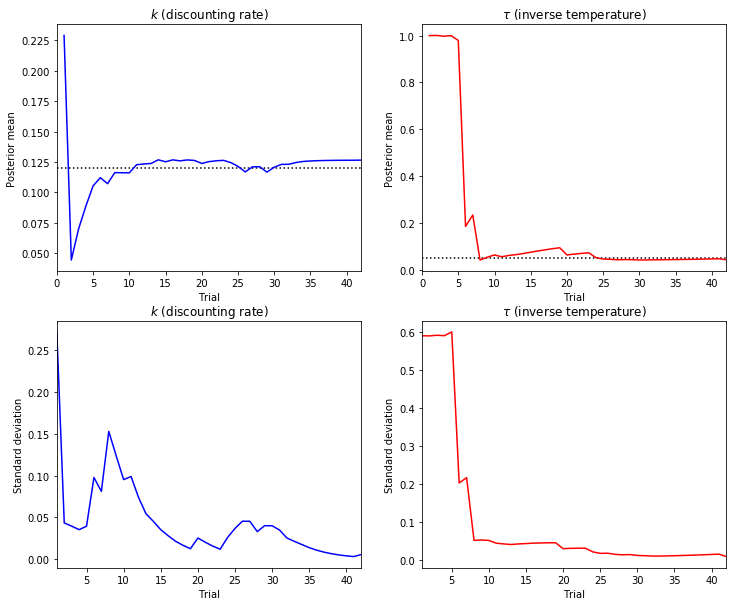

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize = [12, 10])

ax[0, 0].axhline(K, color='black', linestyle=':')
ax[0, 1].axhline(TAU, color='black', linestyle=':')

df.plot(x = 'trial', y = 'mean_k', ax=ax[0, 0], color='blue', legend=False)
df.plot(x = 'trial', y = 'mean_tau', ax=ax[0, 1], color='red', legend=False)

df.plot(x = 'trial', y = 'sd_k', ax=ax[1, 0], color='blue', legend=False)
df.plot(x = 'trial', y = 'sd_tau', ax=ax[1, 1], color='red', legend=False)

ax[0, 0].set_xlabel('Trial'); ax[0, 0].set_ylabel('Posterior mean')
ax[0, 1].set_xlabel('Trial'); ax[0, 1].set_ylabel('Posterior mean')
ax[1, 0].set_xlabel('Trial'); ax[1, 0].set_ylabel('Standard deviation')
ax[1, 1].set_xlabel('Trial'); ax[1, 1].set_ylabel('Standard deviation')

ax[0, 0].set_title('$k$ (discounting rate)')
ax[1, 0].set_title('$k$ (discounting rate)')
ax[0, 1].set_title('$\\tau$ (inverse temperature)')
ax[1, 1].set_title('$\\tau$ (inverse temperature)')

plt.show()

## Design comparison

1. **ADO design**
2. **Fixed design** (Green & Myerson, 2004)
    - The staircase method runs 6 trials for each delay to estimate the discounting rate. While $t_{SS}$ is fixed to 0, it starts with $R_{SS}$ of \\$400 and $R_{LL}$ of \\$800. If a participant chooses the SS option, the staircase method increases $R_{SS}$ by 50\%; if the participant chooses the LL option, it decreases $R_{SS}$ by 50\%. After repeating this 5 times, it proceeds to another delay value.
3. **Random design**

In [36]:
# Prepare an empty DataFrame to store information
df = pd.DataFrame(None, columns=[
    'design_type', 'trial','mean_k', 'mean_tau', 'sd_k', 'sd_tau'
])

# Set the total number of trials to 42.
NUM_TRIAL = 42

# Set the number of independent simulation runs to 10.
NUM_SIMUL = 10

# 7 possible delay values of t_ll for staircase method:
#   [1 week, 2 weeks, 1 month, 6 months,
#    1 year, 2 years, 10 years]
d_vals = [1, 2, 4.3, 26, 53, 106, 530]

In [37]:
for i in range(NUM_SIMUL):
    for design_type in ['ado', 'staircase', 'random']:
        # Reset the engine
        engine.reset()

        np.random.shuffle(d_vals)

        for trial in range(1, NUM_TRIAL + 1):
            # Step 1 - Design optimization
            if design_type == 'ado':
                design = engine.get_design()
            elif design_type == 'random':
                design = engine.get_design('random')
            else:  # design_type == 'staircase'
                if (trial - 1) % 6 == 0:
                    design = {
                        't_ss': 0,   't_ll': d_vals[(trial - 1) // 6],
                        'r_ss': 400, 'r_ll': 800
                    }
                else:
                    design['r_ss'] *= (1.5 if response == 1 else 0.5)

            # Step 2 - Experiment
            response = get_simulated_response(design)

            # Step 3 - Bayesian updating
            engine.update(design, response)

            # Append a row to store information
            df = df.append({
                'design_type': design_type,
                'trial': trial,
                'mean_k': engine.post_mean[0],
                'mean_tau': engine.post_mean[1],
                'sd_k': engine.post_sd[0],
                'sd_tau': engine.post_sd[1]
            }, ignore_index=True)

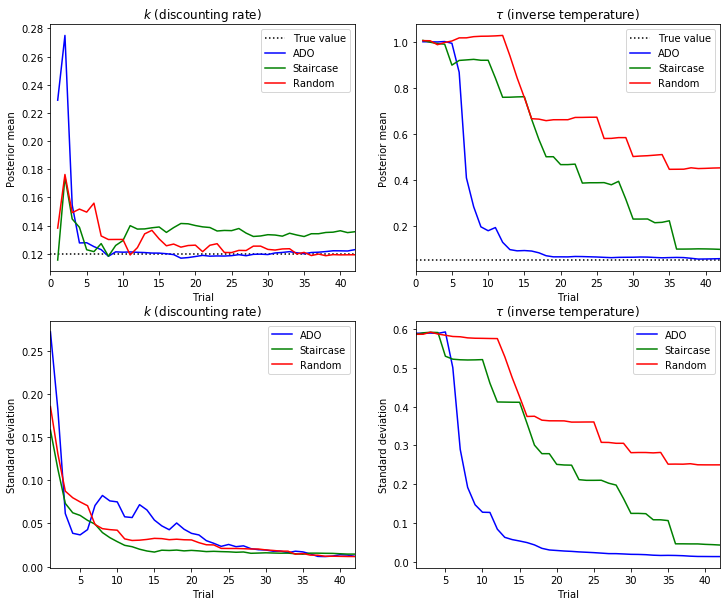

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize = [12, 10])

ax[0, 0].axhline(K, color='black', linestyle=':')
ax[0, 1].axhline(TAU, color='black', linestyle=':')

colors = ['blue', 'green', 'red']
df_mean = df.groupby(['design_type', 'trial']).mean().reset_index()

for i, design_type in enumerate(['ado', 'staircase', 'random']):
    df_tmp = df_mean.loc[df_mean['design_type'] == design_type]
    
    df_tmp.plot(x = 'trial', y = 'mean_k', ax=ax[0, 0], color=colors[i], legend=False)
    df_tmp.plot(x = 'trial', y = 'mean_tau', ax=ax[0, 1], color=colors[i], legend=False)

    df_tmp.plot(x = 'trial', y = 'sd_k', ax=ax[1, 0], color=colors[i], legend=False)
    df_tmp.plot(x = 'trial', y = 'sd_tau', ax=ax[1, 1], color=colors[i], legend=False)

ax[0, 0].set_xlabel('Trial'); ax[0, 0].set_ylabel('Posterior mean')
ax[0, 1].set_xlabel('Trial'); ax[0, 1].set_ylabel('Posterior mean')
ax[1, 0].set_xlabel('Trial'); ax[1, 0].set_ylabel('Standard deviation')
ax[1, 1].set_xlabel('Trial'); ax[1, 1].set_ylabel('Standard deviation')

ax[0, 0].set_title('$k$ (discounting rate)')
ax[1, 0].set_title('$k$ (discounting rate)')
ax[0, 1].set_title('$\\tau$ (inverse temperature)')
ax[1, 1].set_title('$\\tau$ (inverse temperature)')

ax[0, 0].legend(['True value', 'ADO', 'Staircase', 'Random'])
ax[0, 1].legend(['True value', 'ADO', 'Staircase', 'Random'])
ax[1, 0].legend(['ADO', 'Staircase', 'Random'])
ax[1, 1].legend(['ADO', 'Staircase', 'Random'])

plt.show()

## References

Green, L. & Myerson, J. (2004). A discounting framework for choice with delayed and probabilistic rewards. Psychological Bulletin, 130, 769–792.

Mazur, J. E. (1987). An adjusting procedure for studying delayed reinforcement. Commons, ML.; Mazur, JE.; Nevin, JA, 55–73.
